<a href="https://colab.research.google.com/github/Jemka12/Caterpillar/blob/master/MoleModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подключаем библиотеки и подготовляем среду

In [1]:
#ставим более старый PIL(с новым были проблемы)
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

Uninstalling Pillow-6.2.2:
  Successfully uninstalled Pillow-6.2.2
     |████████████████████████████████| 2.0MB 3.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


6.2.2


In [0]:
#портируем библиотеки
import pickle
import numpy as np
import random

import pandas as pd

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torch
from torch.optim import lr_scheduler
from torchvision import transforms, datasets, models
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [0]:
#"Фиксируем" рандом.Для повторения решения
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
#подключаемся 
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


# Работа с датасетом

In [0]:
#скачиваем датасет с кагла ,если нет сета на гугл диске
!mkdir /root/.kaggle
!echo '{"username":"usernamek","key":"key"}' > /root/.kaggle/kaggle.json

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

In [0]:
!unzip -q /content/gdrive/My\ Drive/skin-cancer-mnist-ham10000.zip

In [0]:
def creat_dir(dirr,cr_dir):
  dirr = os.path.join(dirr, cr_dir)
  os.mkdir(dirr)

In [0]:
base_dir = 'base_dir'
os.mkdir(base_dir)

for i in ['train_dir','val_dir']:
  creat_dir(base_dir,i)

train_dir = os.path.join(base_dir, 'train_dir')
for i in ['nv','mel','bkl','bcc','akiec','vasc','df']:
  creat_dir(train_dir,i)

val_dir = os.path.join(base_dir, 'val_dir')
for i in ['nv','mel','bkl','bcc','akiec','vasc','df']:
  creat_dir(val_dir,i)

In [10]:
# this will tell us how many images are associated with each lesion_id
df = mole_date.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [11]:
def identify_duplicates(x):
    unique_list = list(df['lesion_id'])
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

df_data = mole_date   
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,has_duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,has_duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,has_duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,has_duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,has_duplicates


In [0]:
df_data['duplicates'].value_counts()
df = df_data[df_data['duplicates'] == 'no_duplicates']

In [13]:
from sklearn.model_selection import train_test_split
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(938, 8)

In [14]:
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [0]:
import shutil
# Get a list of images in each of the two folders
df_data.set_index('image_id', inplace=True)
folder_1 = os.listdir('/content/ham10000_images_part_1')
folder_2 = os.listdir('/content/ham10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('/content/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/content/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)



In [0]:

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('/content/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/content/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [19]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('/content/base_dir/val_dir')))

5954
1074
1024
484
301
131
7


# Подготовка датасета 


Для борьбой с переобучением добавлена аугментация 




In [0]:
#сортируем датасеты
TRAIN_DIR = Path('/content/base_dir/train_dir')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

In [0]:
TEST_DIR = Path('/content/base_dir/val_dir')
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
#парочка глобальных переменных
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

In [0]:
#подготовка данных
class MoleDataset(Dataset):
  def __init__(self, files, mode, augmentations = None):
    super().__init__()
    self.files = files
    self.mode = mode
    self.augmentations = augmentations
    self.len_ = len(self.files)
    self.label_encoder = LabelEncoder()

    if self.mode != 'test':
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)

      with open('label_encoder.pkl', 'wb') as le_dump:
        pickle.dump(self.label_encoder, le_dump)

  def __len__(self):
    return self.len_

  def load_sample(self, file):
    image = Image.open(file)
    image.load()
    return image

  def __getitem__(self, index):
    transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
    ])
    #добавлена аугментация
    transform_train = transforms.Compose([
      transforms.ToPILImage(mode="RGB"),
      transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
      transforms.RandomRotation(25),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
    ])

    x = self.load_sample(self.files[index])
    x = self._prepare_sample(x)

    #в зависимости от режима работы - картинка обрабатывается по разному
    if self.mode == "train":
      x = transform_train(x)
    else:
      x = transform(x)

    if self.mode == 'test':
      return x
    else:
      label = self.labels[index]
      label_id = self.label_encoder.transform([label])
      y = label_id.item()
      return x, y

  def _prepare_sample(self, image):
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    return np.array(image)




In [0]:
#делим выборку на обучение и проверку

from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)



# Функции обучения и предикт

1.   Изменен начальный lr ,для более глакого схождения градиента 
2.   Для тех же целей добавлен scheduler
3. Так же ,при достижении более высокого val_acc -> сохраняет веса модели


In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc
  
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc
  
def train(train_files, val_files, model, epochs, batch_size):
    best_acc = 0
    
    #добавлен num_workers,для ускорения создания батча
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      
        #Изменен lr, добавлен scheduler
        opt = torch.optim.Adam(model.parameters(),lr=0.0001)
        scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.5)

        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            # сохраняем веса лучшей модели 
            if  val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    # загружаем вес лучшей модели       
    model.load_state_dict(best_model_wts)       
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

# Обучение модели 


1.   Модель - resnet18 и второй вариант -  densnet121
2.   Изменен последний слой.Путем эксперементов ,более высокий скор достигла двухслойная модель 



In [0]:
# подготовляем датасет

val_dataset = MoleDataset(val_files, mode='val')
train_dataset = MoleDataset(train_files, mode='train')



In [0]:
#блок с mobilenet_v2
model_extractor = models.mobilenet_v2(pretrained=True)

num_features = 1280
model_extractor.classifier = nn.Sequential(nn.Linear(num_features, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(),
                                 nn.BatchNorm1d(1024),
                                 nn.Linear(1024, 7),
                                 nn.LogSigmoid())
model_extractor = model_extractor.cuda()

In [27]:
#блок с densnet
model_extractor = models.densenet121(pretrained=True)
num_features = 1024
model_extractor.classifier = nn.Sequential(nn.Linear(num_features, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(),
                                 nn.BatchNorm1d(1024),
                                 nn.Linear(1024, 7),
                                 nn.LogSigmoid())
model_extractor = model_extractor.cuda()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 82.3MB/s]


In [0]:
#блок с resnet
model_extractor = models.resnet50(pretrained=True)
num_features = 2048
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.fc   = nn.Sequential(nn.Linear(num_features, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(),
                                 nn.BatchNorm1d(1024),
                                 nn.Linear(1024, 7),
                                 nn.LogSigmoid())
model_extractor = model_extractor.cuda()

In [0]:
#смотрим на нашу модель
n_classes = len(np.unique(train_val_labels))
print("we will classify :{}".format(n_classes))
print(model_extractor)

In [28]:
#запускаем train
history = train(train_dataset, val_dataset, model=model_extractor, epochs=40, batch_size=84)

epoch:   0%|          | 0/40 [00:00<?, ?it/s]

loss 1.6170575769951383


epoch:   2%|▎         | 1/40 [02:47<1:49:02, 167.75s/it]


Epoch 001 train_loss: 1.6171     val_loss 1.2082 train_acc 0.5366 val_acc 0.6696
loss 0.8172234427730269


epoch:   5%|▌         | 2/40 [05:35<1:46:19, 167.88s/it]


Epoch 002 train_loss: 0.8172     val_loss 0.7187 train_acc 0.7090 val_acc 0.7461
loss 0.6725144846973595


epoch:   8%|▊         | 3/40 [08:22<1:43:12, 167.37s/it]


Epoch 003 train_loss: 0.6725     val_loss 0.6490 train_acc 0.7482 val_acc 0.7627
loss 0.5973464721754027


epoch:  10%|█         | 4/40 [11:14<1:41:23, 168.98s/it]


Epoch 004 train_loss: 0.5973     val_loss 0.5821 train_acc 0.7751 val_acc 0.7753
loss 0.5766651685072722


epoch:  12%|█▎        | 5/40 [14:02<1:38:21, 168.62s/it]


Epoch 005 train_loss: 0.5767     val_loss 0.5752 train_acc 0.7882 val_acc 0.7919
loss 0.5523166474913815


epoch:  15%|█▌        | 6/40 [16:55<1:36:19, 169.98s/it]


Epoch 006 train_loss: 0.5523     val_loss 0.5464 train_acc 0.7890 val_acc 0.7952
loss 0.506757579030716


epoch:  18%|█▊        | 7/40 [19:56<1:35:11, 173.07s/it]


Epoch 007 train_loss: 0.5068     val_loss 0.5298 train_acc 0.8080 val_acc 0.8095
loss 0.4042417458095033


epoch:  20%|██        | 8/40 [22:48<1:32:12, 172.91s/it]


Epoch 008 train_loss: 0.4042     val_loss 0.4644 train_acc 0.8497 val_acc 0.8199
loss 0.36467644674458494


epoch:  22%|██▎       | 9/40 [25:46<1:30:04, 174.33s/it]


Epoch 009 train_loss: 0.3647     val_loss 0.4661 train_acc 0.8657 val_acc 0.8271
loss 0.3589976496964738


epoch:  25%|██▌       | 10/40 [28:50<1:28:42, 177.43s/it]


Epoch 010 train_loss: 0.3590     val_loss 0.4446 train_acc 0.8624 val_acc 0.8392
loss 0.3319220402084456


epoch:  28%|██▊       | 11/40 [31:54<1:26:38, 179.27s/it]


Epoch 011 train_loss: 0.3319     val_loss 0.4258 train_acc 0.8734 val_acc 0.8326
loss 0.3011313672072959


epoch:  30%|███       | 12/40 [34:55<1:23:52, 179.73s/it]


Epoch 012 train_loss: 0.3011     val_loss 0.5074 train_acc 0.8883 val_acc 0.8029
loss 0.270867813176942


epoch:  32%|███▎      | 13/40 [37:58<1:21:17, 180.64s/it]


Epoch 013 train_loss: 0.2709     val_loss 0.4817 train_acc 0.8977 val_acc 0.8359
loss 0.2577827986488328


epoch:  35%|███▌      | 14/40 [40:57<1:18:09, 180.37s/it]


Epoch 014 train_loss: 0.2578     val_loss 0.4713 train_acc 0.9013 val_acc 0.8469
loss 0.19377867471349255


epoch:  38%|███▊      | 15/40 [43:58<1:15:09, 180.40s/it]


Epoch 015 train_loss: 0.1938     val_loss 0.4344 train_acc 0.9287 val_acc 0.8447
loss 0.16132401214673195


epoch:  40%|████      | 16/40 [46:57<1:12:01, 180.07s/it]


Epoch 016 train_loss: 0.1613     val_loss 0.5099 train_acc 0.9394 val_acc 0.8326
loss 0.16310978539143361


epoch:  42%|████▎     | 17/40 [49:57<1:09:00, 180.02s/it]


Epoch 017 train_loss: 0.1631     val_loss 0.4795 train_acc 0.9412 val_acc 0.8442
loss 0.14291578613764458


epoch:  45%|████▌     | 18/40 [52:56<1:05:53, 179.72s/it]


Epoch 018 train_loss: 0.1429     val_loss 0.4626 train_acc 0.9448 val_acc 0.8590
loss 0.12928151815920358


epoch:  48%|████▊     | 19/40 [55:56<1:02:54, 179.76s/it]


Epoch 019 train_loss: 0.1293     val_loss 0.4961 train_acc 0.9506 val_acc 0.8497
loss 0.12501770437724202


epoch:  50%|█████     | 20/40 [58:56<1:00:00, 180.02s/it]


Epoch 020 train_loss: 0.1250     val_loss 0.5079 train_acc 0.9559 val_acc 0.8541
loss 0.11987652206831137


epoch:  52%|█████▎    | 21/40 [1:01:54<56:46, 179.28s/it]


Epoch 021 train_loss: 0.1199     val_loss 0.5208 train_acc 0.9554 val_acc 0.8519
loss 0.08492014646702538


epoch:  55%|█████▌    | 22/40 [1:04:51<53:35, 178.65s/it]


Epoch 022 train_loss: 0.0849     val_loss 0.5159 train_acc 0.9697 val_acc 0.8618
loss 0.06925785008162741


epoch:  57%|█████▊    | 23/40 [1:07:51<50:42, 178.97s/it]


Epoch 023 train_loss: 0.0693     val_loss 0.5464 train_acc 0.9770 val_acc 0.8557
loss 0.06982765971614857


epoch:  60%|██████    | 24/40 [1:10:46<47:27, 177.96s/it]


Epoch 024 train_loss: 0.0698     val_loss 0.5324 train_acc 0.9762 val_acc 0.8722
loss 0.06378637267680162


epoch:  62%|██████▎   | 25/40 [1:13:45<44:31, 178.10s/it]


Epoch 025 train_loss: 0.0638     val_loss 0.5248 train_acc 0.9789 val_acc 0.8667
loss 0.06368493881744058


epoch:  65%|██████▌   | 26/40 [1:16:41<41:25, 177.51s/it]


Epoch 026 train_loss: 0.0637     val_loss 0.5105 train_acc 0.9770 val_acc 0.8711
loss 0.05277397036460079


epoch:  68%|██████▊   | 27/40 [1:19:37<38:23, 177.19s/it]


Epoch 027 train_loss: 0.0528     val_loss 0.6071 train_acc 0.9820 val_acc 0.8656
loss 0.05707092934160206


epoch:  70%|███████   | 28/40 [1:22:34<35:23, 176.96s/it]


Epoch 028 train_loss: 0.0571     val_loss 0.5872 train_acc 0.9820 val_acc 0.8634
loss 0.0401159697534862


epoch:  72%|███████▎  | 29/40 [1:25:28<32:15, 175.99s/it]


Epoch 029 train_loss: 0.0401     val_loss 0.5625 train_acc 0.9866 val_acc 0.8700
loss 0.03819118944586612


epoch:  75%|███████▌  | 30/40 [1:28:26<29:27, 176.77s/it]


Epoch 030 train_loss: 0.0382     val_loss 0.5443 train_acc 0.9894 val_acc 0.8756
loss 0.03649853750631868


epoch:  78%|███████▊  | 31/40 [1:31:16<26:12, 174.67s/it]


Epoch 031 train_loss: 0.0365     val_loss 0.5904 train_acc 0.9884 val_acc 0.8728
loss 0.03307621583990027


epoch:  80%|████████  | 32/40 [1:34:02<22:57, 172.15s/it]


Epoch 032 train_loss: 0.0331     val_loss 0.5862 train_acc 0.9891 val_acc 0.8722
loss 0.029817061748362298


epoch:  82%|████████▎ | 33/40 [1:36:44<19:42, 168.93s/it]


Epoch 033 train_loss: 0.0298     val_loss 0.6291 train_acc 0.9912 val_acc 0.8711
loss 0.030349928051214822


epoch:  85%|████████▌ | 34/40 [1:39:25<16:40, 166.75s/it]


Epoch 034 train_loss: 0.0303     val_loss 0.5931 train_acc 0.9895 val_acc 0.8728
loss 0.03075551341297155


epoch:  88%|████████▊ | 35/40 [1:42:11<13:52, 166.41s/it]


Epoch 035 train_loss: 0.0308     val_loss 0.6182 train_acc 0.9909 val_acc 0.8722
loss 0.024357975961202073


epoch:  90%|█████████ | 36/40 [1:45:17<11:29, 172.40s/it]


Epoch 036 train_loss: 0.0244     val_loss 0.6197 train_acc 0.9934 val_acc 0.8772
loss 0.02798651049419983


epoch:  92%|█████████▎| 37/40 [1:48:20<08:46, 175.48s/it]


Epoch 037 train_loss: 0.0280     val_loss 0.6047 train_acc 0.9912 val_acc 0.8750
loss 0.025098644351929676


epoch:  95%|█████████▌| 38/40 [1:51:15<05:50, 175.47s/it]


Epoch 038 train_loss: 0.0251     val_loss 0.6054 train_acc 0.9923 val_acc 0.8778
loss 0.02267332682985032


epoch:  98%|█████████▊| 39/40 [1:54:02<02:52, 172.76s/it]


Epoch 039 train_loss: 0.0227     val_loss 0.6580 train_acc 0.9949 val_acc 0.8744
loss 0.023696723697439498


epoch: 100%|██████████| 40/40 [1:56:49<00:00, 170.98s/it]


Epoch 040 train_loss: 0.0237     val_loss 0.6352 train_acc 0.9930 val_acc 0.8761


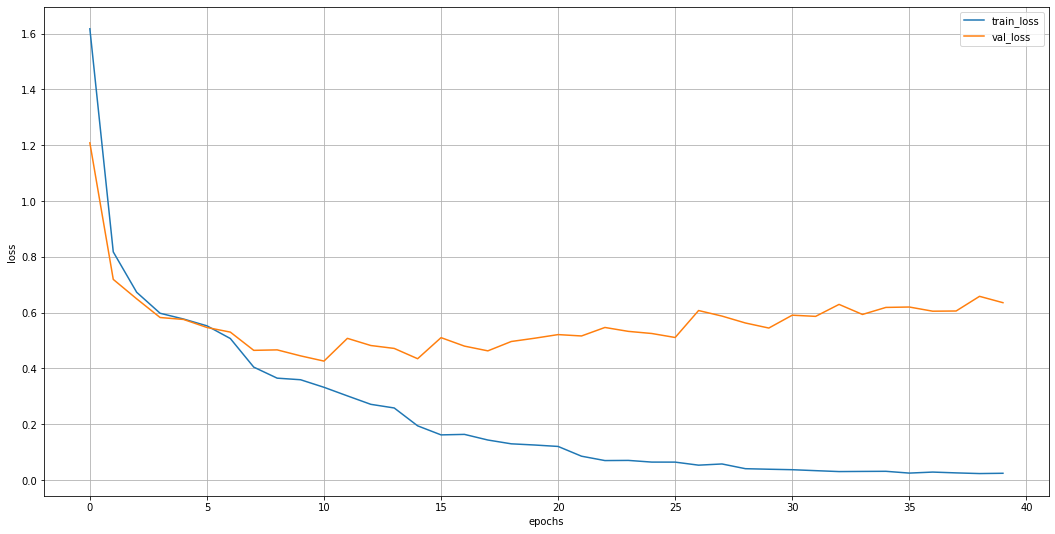

In [48]:
#смотрим на то ,как обучалась модель
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(18, 9))
plt.grid()
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

In [30]:
np.max(val_acc)

tensor(0.8778, device='cuda:0', dtype=torch.float64)

# Портируем модель в .pt

In [0]:
model_extractor.eval()
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(model_extractor.cpu(), example)
traced_script_module.save("/content/gdrive/My Drive/Шифт_Модели_2020/Densenet_f1_.849_v0_7nOut_Tiptiuk_Nikita.pt")

In [0]:
model_extractor.eval()
torch.save(model_extractor.state_dict(),'/content/gdrive/My Drive/Densnetweight_7nOut_Tiptiuk_Nikita_state_dict.pth')

In [0]:
test_files = (list([Path("/content/data/test/benign/1.jpg")]))
test_dataset = MoleDataset(test_files, mode="test")

In [0]:
test_loader = DataLoader(test_dataset , shuffle=False, batch_size=1)
predict(model_extractor,test_loader)
print(labels.to(DEVICE))

NameError: ignored

In [0]:
test_dataset = MoleDataset(test_files, mode="test")
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_extractor, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

my_submit.to_csv('/content/gdrive/My Drive/simpson_dataset/simple4_cnn_baseline.csv', index=False)

# Score


In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
test_dataset = MoleDataset(test_files, mode='val')

In [36]:
len(test_files)

938

In [0]:
model_extractor.eval()
imgs = [test_dataset[id][0].unsqueeze(0) for id in range(938)]
probs_ims = predict(model_extractor.cuda(), imgs)
preds_class = np.argmax(probs_ims,-1)

In [0]:
test_val_labels = [path.parent.name for path in test_files]
actual_labels = label_encoder.transform(test_val_labels)

In [40]:
from sklearn.metrics import accuracy_score

accuracy_score(actual_labels, preds_class)

0.9136460554371002

In [0]:
def classifi(imgs):
  model_extractor.eval()
  probs_ims = predict(model_extractor.cuda(), imgs)
  preds_class = np.argmax(probs_ims,-1)
  return preds_class

In [86]:
 y_true

array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype='<U5')

In [125]:
cnf_matrix = metrics.confusion_matrix(actual_labels, preds_class, normalize=None)
cnf_matrix

array([[ 14,   4,   3,   0,   3,   2,   0],
       [  1,  27,   1,   0,   0,   1,   0],
       [  3,   0,  49,   1,   9,  13,   0],
       [  0,   0,   0,   2,   1,   3,   0],
       [  1,   2,   3,   0,  20,  12,   1],
       [  3,   3,   5,   0,   6, 734,   0],
       [  0,   0,   0,   0,   0,   0,  11]])

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
   

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

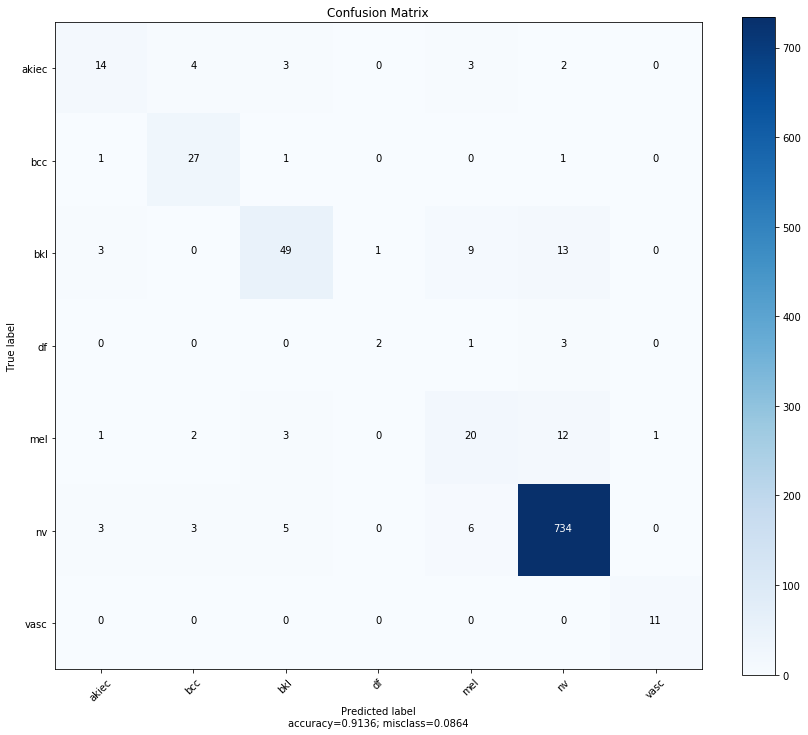

In [128]:
plot_confusion_matrix(cnf_matrix, 
                      normalize    = False,
                      target_names =  y_true,
                      title        = "Confusion Matrix")

# imshow
Посмотрим на то ,с какой вероятностью и что предсказывает модель

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [77]:
label_encoder.classes_

array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype='<U5')

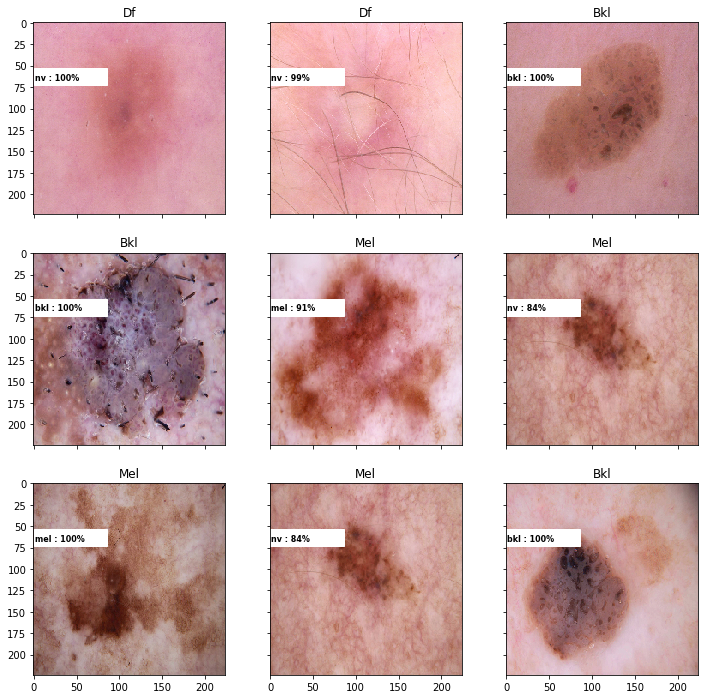

In [74]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12),sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(100,150))
    im_val, label = test_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
               test_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(),title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,20,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_extractor, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [0]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

In [0]:
!pip install python-telegram-bot
!pip install -U ipykernel

In [0]:
#from model import StyleTransferModel
#from telegram_token import token
from io import BytesIO

In [0]:
# В бейзлайне пример того, как мы можем обрабатывать две картинки, пришедшие от пользователя.
model = model_extractor
first_image_file = {}

In [0]:
def process_image( img_stream):
        # TODO размер картинки, device и трансформации не меняются в течении всей работы модели,
        # поэтому их нужно перенести в конструктор!
        imsize = 224
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(device)
        loader = transforms.Compose([
            transforms.Resize(imsize),  # нормируем размер изображения
            transforms.CenterCrop(imsize),
            transforms.ToTensor()])  # превращаем в удобный формат

        image = Image.open(img_stream)
        image = loader(image).unsqueeze(0)
        return image.to(device, torch.float)

In [0]:
def prepare(image):
    transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
    ])
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    image = np.array(image)
    return(transform(image))

In [0]:
def send_prediction_on_photo(bot, update):
    # Нам нужно получить две картинки, чтобы произвести перенос стиля, но каждая картинка приходит в
    # отдельном апдейте, поэтому в простейшем случае мы будем сохранять id первой картинки в память,
    # чтобы, когда уже придет вторая, мы могли загрузить в память уже сами картинки и обработать их.
    # Точно место для улучшения, я бы
    print("dw")
    chat_id = update.message.chat_id
    print("Got image from {}".format(chat_id))
    bot.send_message(chat_id=update.message.chat_id, text="Принял фото")
    # получаем информацию о картинке
    image_info = update.message.photo[-1]
    image_file = bot.get_file(image_info)

    if chat_id in first_image_file:
        # первая картинка, которая к нам пришла станет content image, а вторая style image
        content_image_stream = BytesIO()
        first_image_file[chat_id].download(out=content_image_stream)
        del first_image_file[chat_id]


        output = model(process_image(prepare(Image.open(content_image_stream))))
        print(output)
        bot.send_message(chat_id=update.message.chat_id, text=output)
        
        print("Sent Message")
    else:
        first_image_file[chat_id] = image_file

In [0]:
def start(update, context):
    """Send a message when the command /start is issued."""
    update.message.reply_text('Hi!')

In [0]:
if __name__ == '__main__':
    from telegram.ext import Updater, MessageHandler, Filters, CommandHandler
    import logging

    token = "1007080640:AAHzJpoIAsOOL5bKSjaWbz9FflKpaqD02Vo"
    # Включим самый базовый логгинг, чтобы видеть сообщения об ошибках
    logging.basicConfig(
        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        level=logging.INFO)
    # используем прокси, так как без него у меня ничего не работало.
    # если есть проблемы с подключением, то попробуйте убрать прокси или сменить на другой
    # прокси ищется в гугле как "socks4 proxy"

    updater = Updater('1007080640:AAHzJpoIAsOOL5bKSjaWbz9FflKpaqD02Vo',use_context=False, request_kwargs={'proxy_url': 'socks5h://163.172.152.192:1080'})
    dp = updater.dispatcher

    # on different commands - answer in Telegram
    dp.add_handler(CommandHandler("start", start))
    # В реализации сложных диалогов скорее всего будет удобнее использовать Conversation Handler
    # вместо назначения handler'ов таким способом
    dp.add_handler(MessageHandler(Filters.photo, send_prediction_on_photo))
    updater.start_polling()

    updater.idle()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TelegramDeprecationWarning: Old Handler API is deprecated - see https://git.io/fxJuV for details
  


dw
Got image from 258862724
dw
Got image from 258862724


2020-01-29 12:57:03,146 - telegram.ext.dispatcher - ERROR - No error handlers are registered, logging exception.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/PIL/Image.py", line 2613, in open
    fp.seek(0)
AttributeError: 'Tensor' object has no attribute 'seek'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/telegram/ext/dispatcher.py", line 372, in process_update
    handler.handle_update(update, self, check, context)
  File "/usr/local/lib/python3.6/dist-packages/telegram/ext/handler.py", line 120, in handle_update
    return self.callback(dispatcher.bot, update, **optional_args)
  File "<ipython-input-39-8369cab87d0f>", line 21, in send_prediction_on_photo
    output = model(process_image(prepare(Image.open(content_image_stream))))
  File "<ipython-input-24-5a06d2a2ea66>", line 12, in process_image
    image = Image.open(img_stream)
  File "/u

cuda


2020-01-29 12:57:29,843 - telegram.ext.updater - INFO - Received signal 2 (SIGINT), stopping...
